In [1]:
import price_process.process as pp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import moment

In [40]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
def monte_carlo_call_price(strike, price_data, verbose=True):
    price = price_data.process
    r = price_data.drift
    discount = np.exp(-price_data.T*r)
    p_filtered = price[-1, :]
    # put_price = np.mean(np.maximum(np.zeros(len(p_filtered)),-p_filtered+strike))*discount
    call_price = np.mean(np.maximum(np.zeros(len(p_filtered)),p_filtered-strike))*discount
    if verbose:
        print("MC call price", round(call_price, 3))
        # print("MC put price", round(put_price,3))
        plt.hist(price[-1,:], bins=np.linspace(0,1.5,60), alpha=0.5);

    return call_price

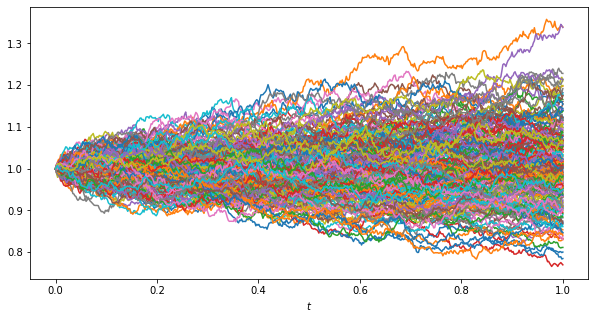

MC call price 0.041
MC put price 0.039


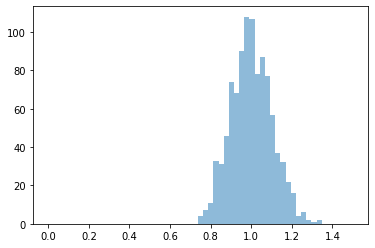

In [37]:
data = pp.Gaussian([500,1000], T=1).to_geometric(0.01, 0.1)
data.plot(num_to_plot=200)
c= monte_carlo_call_price(1, data)



In [38]:
def grid_data_gen(vol_bounds=(0.05,25,10), T_bounds=(0.2,4,10), r_bounds=(0, 0.1,10)):
    vols = np.linspace(*vol_bounds)
    Ts = np.linspace(*T_bounds)
    rs = np.linspace(*r_bounds)
    for iv, vol in enumerate(vols):
        for iT, T in enumerate(Ts):
            for ir, r in enumerate(rs):
                data = pp.Gaussian([500,1000], T=T).to_geometric(r, vol)
                c = monte_carlo_call_price(1, data)
                features = 


In [41]:
for i, a in enumerate([3,2,1]):
    print(i, a)

0 3
1 2
2 1
